### Wandb connect

In [1]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/siddesh/.netrc
wandb: Currently logged in as: cs21b2019 (cs21b2019-iiitdm-kancheepuram) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
wandb.init(project="brats-diffusion")

### Imports

In [1]:
# Imports
import torch
import os
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange #pip install einops
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from timm.utils import ModelEmaV3 #pip install timm
from tqdm import tqdm #pip install tqdm
import matplotlib.pyplot as plt #pip install matplotlib
import torch.optim as optim
import numpy as np
import nibabel as nib
from sklearn.metrics import roc_auc_score
from skimage.filters import threshold_otsu

### Utils

#### Logging

In [2]:
def print_log(message):
    print(f"[Log] {message}")

#### Normalize images

In [3]:
def normalize_images(images):
    return (images - 0.5) / 0.5

# def normalize_images(images): # Normalize images to [-1, 1] using min-max scaling
#     min_val = images.min()
#     max_val = images.max()
#     return 2 * (images - min_val) / (max_val - min_val) - 1

In [4]:
def visualize_image(image):
    min_val = image.min()
    max_val = image.max()
    normalize_image = (image - min_val) / (max_val - min_val)
    return normalize_image

#### Set device

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print_log(f"Using device: {device}")

[Log] Using device: cpu


#### Save Checkpoint

In [6]:
def save_checkpoint(model, optimizer, ema, filename, folder='../checkpoints'):
    checkpoint_path = os.path.join(folder, filename)

    checkpoint = {
        'weights': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'ema': ema.state_dict()
    }

    torch.save(checkpoint, checkpoint_path)
    print(f"[INFO] Checkpoint saved at: {checkpoint_path}")

#### Dice Score

In [ ]:
def dice_score(pred, target, eps=1e-6):
    """Compute Dice score between a single prediction and target."""
    # Ensure both are tensors
    pred = torch.as_tensor(pred, dtype=torch.float32)
    target = torch.as_tensor(target, dtype=torch.float32)

    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    
    dice = (2. * intersection + eps) / (union + eps)
    
    return dice.item()  # Ensure a scalar is returned


#### OTSU's Thresholding

In [8]:
def apply_otsu_thresholding(image):
    # Convert image to numpy array if it's not already
    image = np.asarray(image)

    # Compute Otsu's threshold
    thresh = threshold_otsu(image)

    # Apply thresholding
    binary_image = (image > thresh).astype(np.uint8)

    return binary_image

### Early Stopping

In [9]:
class EarlyStopping:
    def __init__(self, patience=5, delta=1e-4, model_path="best_model.pth"):
        self.patience = patience
        self.delta = delta  # Minimum improvement threshold
        self.best_score = None
        self.counter = 0
        self.model_path = model_path  # Save the best model

    def step(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
            return False

        elif val_loss < self.best_score - self.delta:  # Require significant improvement
            self.best_score = val_loss
            self.counter = 0
            self.save_checkpoint(model)  # Save best model
            return False

        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early Stopping Triggered.")
                return True  # Stop training
            return False

    def save_checkpoint(self, model):
        """Save the model when validation loss improves."""
        torch.save(model.state_dict(), self.model_path)
        print(f"Model saved with val_loss: {self.best_score:.6f}")

### Data Loader

In [10]:
class BRATSDataset(torch.utils.data.Dataset):
    def __init__(self, directory, test_flag=False, resize=False):
        super().__init__()
        self.directory = os.path.expanduser(directory)
        self.test_flag = test_flag
        self.seqtypes = ['t1', 't1ce', 't2', 'flair']
        self.seqtypes_set = set(self.seqtypes)
        self.resize = resize
        self.database = []

        for root, dirs, files in os.walk(self.directory):
            if not dirs:  # Leaf directory
                datapoint = {}
                seg_path = None  # For segmentation mask
                
                for f in sorted(files):
                    parts = f.split('_')
                    seqtype = parts[3] if len(parts) > 3 else None
                    
                    if seqtype in self.seqtypes_set:
                        datapoint[seqtype] = os.path.join(root, f)
                    elif 'seg' in f.lower():  # Identify segmentation file
                        seg_path = os.path.join(root, f)

                if set(datapoint.keys()) == self.seqtypes_set and (not self.test_flag or seg_path):
                    datapoint['seg'] = seg_path  # Add segmentation path if test_flag=True
                    self.database.append(datapoint)

    def __getitem__(self, index):
        filedict = self.database[index]
        images = []

        for seqtype in self.seqtypes:
            img = nib.load(filedict[seqtype]).get_fdata()
            img = torch.tensor(img, dtype=torch.float32)

            if self.resize:
                img = F.interpolate(img.unsqueeze(0).unsqueeze(0), size=(128, 128), mode="bilinear", align_corners=False)
                img = img.squeeze()

            images.append(img)

        images = torch.stack(images)  # Shape: (4, H, W)

        if self.test_flag:
            seg_img = nib.load(filedict['seg']).get_fdata()
            seg_img = torch.tensor(seg_img, dtype=torch.float32)

            if self.resize:
                seg_img = F.interpolate(seg_img.unsqueeze(0).unsqueeze(0), size=(128, 128), mode="nearest")
                seg_img = seg_img.squeeze()

            return images, seg_img  # Return segmentation image instead of path

        return images

    def __len__(self):
        return len(self.database)

### Timestep embedding

In [11]:
class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps: int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps, dtype=torch.float32).unsqueeze(1)
        div = torch.exp(torch.arange(0, embed_dim, 2, dtype=torch.float32) * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.register_buffer('embeddings', embeddings)

    def forward(self, x, t):
        return self.embeddings[t].to(x.device)[:, :, None, None]

### Residual Blocks

In [12]:
# Residual Blocks
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

### Self Attention

In [13]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads: int, dropout_prob: float):
        super().__init__()
        self.num_heads = num_heads
        self.proj1 = nn.Linear(C, C * 3)
        self.proj2 = nn.Linear(C, C)
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q, k, v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q, k, v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

### UNet

In [14]:
class UnetLayer(nn.Module):
    def __init__(self,
            upscale: bool,
            attention: bool,
            num_groups: int,
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C, num_groups, dropout_prob)
        self.ResBlock2 = ResBlock(C, num_groups, dropout_prob)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C//2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C*2, kernel_size=3, stride=2, padding=1)
        self.attention_layer = Attention(C, num_heads, dropout_prob) if attention else None

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if self.attention_layer:
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 2,
            input_channels: int = 4,
            output_channels: int = 4,
            time_steps: int = 500):

        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))

        out_channels = (Channels[-1] // 2) + Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels // 2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels // 2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

        # Initialize UNet layers
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        embeddings = self.embeddings(x, t)
        residuals = []

        for i in range(self.num_layers // 2):
            layer = getattr(self, f'Layer{i+1}')
            x, res = layer(x, embeddings)
            residuals.append(res)

        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

### Scheduler

In [15]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps=1000):
        super().__init__()
        print_log(f"Using {num_time_steps} time steps.")
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.register_buffer('alpha', torch.cumprod(alpha, dim=0))

    def forward(self, t):
        return self.alpha[t]

In [16]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

### Training

In [17]:
def train(batch_size: int=16,
          num_time_steps: int=500,
          num_epochs: int=15,
          seed: int=-1,
          ema_decay: float=0.9999,
          lr=2e-5,
          data_dir: str='/healthy',
          checkpoint_path: str=None):

    # Set random seed
    seed = random.randint(0, 2**32-1) if seed == -1 else seed
    print_log(f"Random seed set to: {seed}")
    set_seed(seed)

    # Load dataset
    print_log("Loading dataset...")

    train_dataset = BRATSDataset(directory=data_dir)
    print_log(f"Dataset length: {len(train_dataset)}")

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=16, pin_memory=True)

    try:
        sample_batch = next(iter(train_loader))
        print_log(f"First batch shape: {sample_batch.shape}")
    except Exception as e:
        print(f"[ERROR] DataLoader issue: {e}")
        return

    _, H, W = sample_batch.shape[1:]

    # Initialize model
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    model = UNET(
        input_channels=4,
        output_channels=4,
        Channels=[64, 128, 256, 512, 512, 384] if max(H, W) <= 256 else [32, 64, 128, 256, 256, 192]
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    ema = ModelEmaV3(model, decay=ema_decay)

    # Load checkpoint
    if checkpoint_path is not None and os.path.exists(checkpoint_path):
        print_log("Loading checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location="cpu")
        model.load_state_dict(checkpoint['weights'])
        ema.load_state_dict(checkpoint['ema'])
        optimizer.load_state_dict(checkpoint['optimizer'])

    criterion = nn.MSELoss(reduction='mean')
    try:
        iteration = 0
        print_log(f"Starting training for {num_epochs} epochs...")

        for i in range(num_epochs):
            print_log(f"Starting epoch {i+1}/{num_epochs}...")
            total_loss = 0

            for bidx, x in enumerate(tqdm(train_loader, desc=f"----------------------------------------------------------------\nEpoch {i+1}/{num_epochs}\n")):
                print("")
                print_log(f"Processing batch {bidx+1}/{len(train_loader)}...")

                x = x.to(device)
                print_log(f"Batch shape: {x.shape}")

                # Normalize to [-1, 1]
                x = normalize_images(x)

                # Resize if necessary
                if max(H, W) > 256:
                    x = F.interpolate(x, size=(256, 256), mode='bilinear', align_corners=False)

                t = torch.randint(0, num_time_steps, (x.shape[0],)).to(device)
                e = torch.randn_like(x, requires_grad=False).to(device)
                a = scheduler.alpha.to(device)[t].view(x.shape[0], 1, 1, 1)

                x = (torch.sqrt(a) * x) + (torch.sqrt(1 - a) * e)

                # Apply diffusion
                output = model(x, t)
                optimizer.zero_grad()
                loss = criterion(output, e)

                wandb.log(
                    {
                        "iteration": iteration,
                        "loss": loss.item(),
                        "batch": bidx+1,
                    }
                )

                iteration += 1
                total_loss += loss.item()
                print_log(f"Loss: {loss.item()}")

                loss.backward()
                optimizer.step()
                ema.update(model)

            print_log(f"Epoch {i+1} | Loss {total_loss / len(train_loader):.5f}")

            wandb.log(
                {
                    "epoch": i+1,
                    "loss": total_loss / len(train_loader),
                }
            )

            # Save checkpoint every 5 epochs
            if (i + 1) % 5 == 0:
                save_checkpoint(model, optimizer, ema, f'brats_ddpm_checkpoint_epoch_{i+1}.pth')

    except KeyboardInterrupt:
        print("\n[WARNING] Training interrupted. Saving last checkpoint...")
        save_checkpoint(model, optimizer, ema, 'brats_ddpm_interrupted_checkpoint.pth')

    print_log("Training complete.")
    save_checkpoint(model, optimizer, ema, 'brats_ddpm_final_checkpoint.pth')


In [18]:
def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

def inference(checkpoint_path: str=None,
              num_time_steps: int=1000,
              ema_decay: float=0.9999, ):
    checkpoint = torch.load(checkpoint_path)
    model = UNET().cpu()
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(10):
            z = torch.randn(1, 1, 32, 32)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.cpu(),t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, 32, 32)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.cpu(),[0]).cpu())

            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
            x = x.numpy()
            plt.imshow(x)
            plt.show()
            display_reverse(images)
            images = []

### Main

In [19]:
# Define paths
CHECKPOINT_DIR = "../checkpoints"
# os.makedirs(CHECKPOINT_DIR, exist_ok=True)
num_epochs = 100

print(f"Training for only {num_epochs} epochs!")

def main():
    train(
        data_dir="../healthy",
        batch_size=2,
        checkpoint_path=None,
        lr=1e-4,
        num_epochs=num_epochs
    )
    # inference(os.path.join(CHECKPOINT_DIR, "ddpm_checkpoint"))

if __name__ == '__main__':
    main()

Training for only 100 epochs!
[Log] Random seed set to: 833225897
[Log] Loading dataset...
[Log] Dataset length: 0


ValueError: num_samples should be a positive integer value, but got num_samples=0

### Debug

In [19]:
# Debug dataset loading
train_dataset = BRATSDataset(directory="/content/data/healthy")
print("[DEBUG] Dataset length:", len(train_dataset))

# Try loading a single batch
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True, num_workers=0)  # Reduce num_workers
x = next(iter(train_loader))  # Try fetching one batch
x = x.to(device).float()  # Move batch to GPU
print("[DEBUG] First batch loaded:", x.shape)

[DEBUG] Dataset length: 5680
[DEBUG] First batch loaded: torch.Size([2, 4, 128, 128])


In [20]:
scheduler = DDPM_Scheduler(num_time_steps=1000)

# Move model to GPU
model = UNET(
          input_channels=4,
          output_channels=4,
          Channels=[64, 128, 256, 512, 512, 384]
      ).to(device)  # Move model to GPU

print("[DEBUG] Model initialized successfully.")

[DEBUG] Model initialized successfully.


In [21]:
# Load a batch and move to GPU
x = next(iter(train_loader)).to(device).float()
t = torch.randint(0, 500, (x.shape[0],)).to(device)

print("[DEBUG] Running model forward pass...")
# output = model(x, t)  # Forward pass
print("[DEBUG] Forward pass successful, output shape:", output.shape)

[DEBUG] Running model forward pass...
[DEBUG] Forward pass successful, output shape: torch.Size([2, 4, 128, 128])


## Sampling

### Forward Process

In [176]:
def forward_process(image, t, scheduler, device):
    """Applies forward diffusion to an image at time step t."""
    image = normalize_images(image).to(device)
    a = scheduler.alpha[t-1].view(1, 1, 1, 1).to(device)
    e = torch.randn_like(image, device=device)  # Sample noise
    noisy_image = torch.sqrt(a) * image + torch.sqrt(1 - a) * e
    return noisy_image

### Reverse Process

In [177]:
def reverse_process(x_noisy, start_t, scheduler, model, device):
    """Performs reverse diffusion (denoising) from a noisy image."""
    x = x_noisy.clone().to(device)
    
    # Perform reverse diffusion process
    for t in range(start_t, 0, -1):
        print(f"Processing time step {t}...")
        t_tensor = torch.tensor([t-1], device=device)
        noise_pred = model(x, t_tensor)

        a = scheduler.alpha[t-1].view(1, 1, 1, 1).to(device)
        beta_t = scheduler.beta[t-1].view(1, 1, 1, 1).to(device)

        # reverse step
        x = (x - (beta_t / torch.sqrt(1 - a)) * noise_pred) / torch.sqrt(1 - beta_t)

        # Add noise for stochasticity
        # if t > 0:  
        #     noise = torch.randn_like(x, device=device)
        #     x = x + noise * torch.sqrt(beta_t)

    return x

### Sample and Evaluate

In [178]:
import matplotlib.pyplot as plt

def save_image(tensor, path, cmap='gray'):
    """Save a tensor as an image."""
    plt.imsave(path, tensor.cpu().numpy(), cmap=cmap)

def evaluate(model, dataloader, scheduler, num_time_steps, output_dir="output"):
    dice_scores, auroc_scores = [], []
    all_results = []  # Store results for each data item

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    with torch.no_grad():
        for idx, (image, ground_truth_seg) in enumerate(tqdm(dataloader, desc="Evaluating")):
            try:
                image = image.to(device)
                ground_truth_seg = ground_truth_seg.squeeze(0).to(device)

                # Forward diffusion
                noisy_image = forward_process(image=image, t=num_time_steps, scheduler=scheduler, device=device)
                
                # Reverse diffusion (denoising)
                output = reverse_process(x_noisy=noisy_image, start_t=num_time_steps, scheduler=scheduler, model=model, device=device)

                # Compute anomaly map
                image, output = image.squeeze(0), output.squeeze(0)
                # print("Computing anomaly map...", image.shape, output.shape)
                anomaly_map = torch.abs(visualize_image(image) - visualize_image(output)).sum(dim=0)
                # print("Anomaly shape:", anomaly_map.shape)

                # Apply Otsu thresholding
                binary_mask = apply_otsu_thresholding(anomaly_map)
                ground_truth_mask = (ground_truth_seg > 0).float()

                # Compute Dice score
                # print("Computing Dice score...")
                dice = dice_score(binary_mask, ground_truth_mask)

                # Flatten anomaly map and ground truth for AUROC calculation
                pixel_wise_cls = anomaly_map.flatten().cpu().numpy()
                pixel_wise_gt = ground_truth_mask.flatten().cpu().numpy()

                # Compute AUROC
                # print("Computing AUROC...")
                print(pixel_wise_cls.shape, pixel_wise_gt.shape)
                auroc = roc_auc_score(pixel_wise_gt, pixel_wise_cls)

                # Save images
                # print("Saving images...")
                # print("Ground truth shape:", ground_truth_seg.shape)
                # print("Anomaly map shape:", anomaly_map.shape)
                save_image(ground_truth_seg, os.path.join(output_dir, f"ground_truth_{idx}.png"), "gray")
                # save_image(output[0], os.path.join(output_dir, f"model_output_{idx}.png"))
                save_image(anomaly_map, os.path.join(output_dir, f"anomaly_map_{idx}.png"), "hot")

                # Save individual result
                all_results.append({"sample_idx": idx, "dice": dice, "auroc": auroc})
                # all_results.append({"sample_idx": idx, "dice": dice, "auroc": 0})
                
                dice_scores.append(dice)
                auroc_scores.append(auroc)
                
            except Exception as e:
                print(f"Error processing batch {idx}: {e}")
                continue

    if not dice_scores:
        print("No results found.")
        return 0.0, 0.0, []
        
    return np.mean(dice_scores), np.mean(auroc_scores), all_results


### Validate Checkpoints

In [179]:
# Initialize the model
model = UNET(
    output_channels=4,
    input_channels=4,
    Channels=[64, 128, 256, 512, 512, 384],
    time_steps=500
).to(device)

def test_checkpoints(val_data_path, checkpoint_dir, batch_numbers, scheduler, num_time_steps):
    val_dataset = BRATSDataset(directory=val_data_path, test_flag=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
    
    log_file = open("checkpoint_scores.log", "w")
    detailed_log_file = open("detailed_checkpoint_scores.log", "w")
    best_checkpoint, best_dice = None, 0

    try:
        for batch_number in batch_numbers:
            for checkpoint in sorted(os.listdir(checkpoint_dir)):
                if f"epoch_{batch_number}" in checkpoint:
                    print(f"\nTesting {checkpoint}")

                    checkpoint_path = os.path.join(checkpoint_dir, checkpoint)
                    checkpoint_data = torch.load(checkpoint_path, map_location=device)
                    model.load_state_dict(checkpoint_data["weights"])
                    model.eval()

                    avg_dice, avg_auroc, all_results = evaluate(model, val_loader, scheduler, num_time_steps=num_time_steps)

                    # Log summary stats
                    log_entry = f"Checkpoint: {checkpoint} | Dice: {avg_dice:.4f} | AUROC: {avg_auroc:.4f}\n"
                    print(log_entry)
                    log_file.write(log_entry)
                    
                    # Log detailed results
                    detailed_log_file.write(f"\n========== Checkpoint: {checkpoint} ==========\n")
                    detailed_log_file.write("Sample_idx, Dice, AUROC\n")
                    for result in all_results:
                        detailed_log_file.write(f"{result['sample_idx']}, {result['dice']:.4f}, {result['auroc']:.4f}\n")
                    detailed_log_file.write(f"AVERAGE, {avg_dice:.4f}, {avg_auroc:.4f}\n")
                    detailed_log_file.write("=========================================\n")

                    if avg_dice > best_dice:
                        best_dice = avg_dice
                        best_checkpoint = checkpoint

                    torch.cuda.empty_cache()
    finally:
        log_file.close()
        detailed_log_file.close()
        print(f"\nBest Checkpoint: {best_checkpoint} with Dice: {best_dice:.4f}")

### Test

In [184]:
num_time_steps = 400
val_data_path = "val-test/val"
checkpoint_dir = "checkpoints"
scheduler = DDPM_Scheduler(num_time_steps=num_time_steps).to(device)
batch_numbers = [40]
test_checkpoints(val_data_path, checkpoint_dir, batch_numbers, scheduler, num_time_steps)

[Log] Using 400 time steps.

Testing brats_ddpm_checkpoint_epoch_40.pth


Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Processing time step 400...
Processing time step 399...
Processing time step 398...
Processing time step 397...
Processing time step 396...
Processing time step 395...
Processing time step 394...
Processing time step 393...
Processing time step 392...
Processing time step 391...
Processing time step 390...
Processing time step 389...
Processing time step 388...
Processing time step 387...
Processing time step 386...
Processing time step 385...
Processing time step 384...
Processing time step 383...
Processing time step 382...
Processing time step 381...
Processing time step 380...
Processing time step 379...
Processing time step 378...
Processing time step 377...
Processing time step 376...
Processing time step 375...
Processing time step 374...
Processing time step 373...
Processing time step 372...
Processing time step 371...
Processing time step 370...
Processing time step 369...
Processing time step 368...
Processing time step 367...
Processing time step 366...
Processing time step

Evaluating: 100%|██████████| 1/1 [1:09:50<00:00, 4190.25s/it]

In Dice score function
(57600,) (57600,)
Checkpoint: brats_ddpm_checkpoint_epoch_40.pth | Dice: 0.2583 | AUROC: 0.8681


Best Checkpoint: brats_ddpm_checkpoint_epoch_40.pth with Dice: 0.2583


### Plot an image

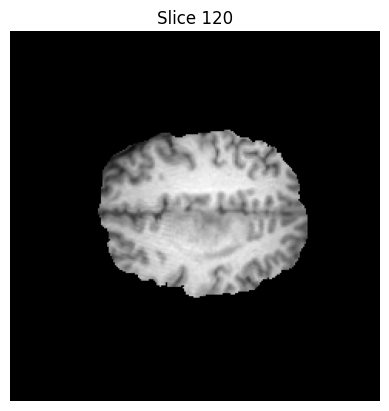

In [69]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

def plot_nii(nii_path, slice_idx=None):
    """
    Plots a given slice of a single-channel NIfTI (.nii or .nii.gz) image.

    Args:
        nii_path (str): Path to the .nii or .nii.gz file.
        slice_idx (int, optional): Index of the slice to display. Defaults to the middle slice.
    """
    nii_img = nib.load(nii_path)
    img_data = nii_img.get_fdata()  # Convert to numpy array

    # Get slice index
    if slice_idx is None:
        slice_idx = img_data.shape[-1] // 2  # Use last axis for slicing

    # Plot the selected slice
    plt.imshow(img_data[:, :], cmap="gray")
    plt.axis("off")
    plt.title(f"Slice {slice_idx}")
    plt.show()


plot_nii("val-test/val/000077/BraTS20_Training_321_t1_107.nii")